In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf


In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(459, 640, 3)


## 세그멘테이션으로 사람 분리하기


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


temp directory: /home/aiffel-dj57/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(459, 640, 3) (367, 513, 3) 18


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)


21

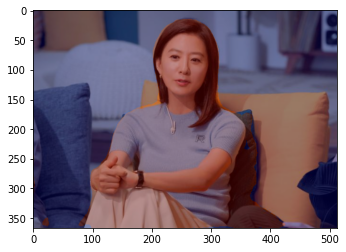

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


## 세그멘테이션 결과를 원래 크기로 복원하기

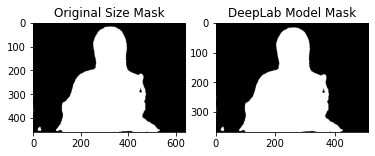

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

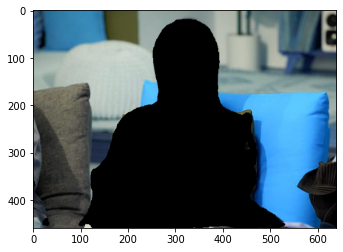

In [9]:
# 배경을 분리해줍니다. 
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

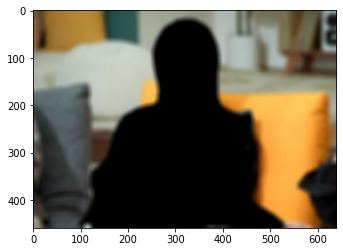

In [10]:
#cv2를 사용해 이미지에 블러처리를 해줍니다.
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

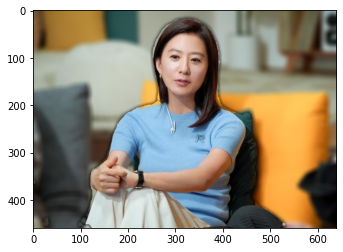

In [11]:
#블러처리된 배경과 원본 이미지를 합성해줍니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점 : 외곽라인이 너무 강하게 생겨서 자연스럽지 않음

## 섬세하지 않은 외곽이 형성되는 이유 : upsampling
단순히 upsampling을 시행하면, 특성맵의 크기는 원래 이미지 크기로 복원되고, 그것들로부터 원래 이미지 크기의 segmentation map을 얻게 되지만 디테일하지 못한 segmentation map을 얻게 된다. 1/32만큼 줄어든 특성맵들을 단숨에 32배만큼 upsampling 했기 때문에 당연히 디테일은 뭉개지게 된다.

# 다양한 이미지 처리 시도해보기.     
# 고양이 사진과 크로마키

In [12]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig2 = cv2.imread(img_path2) 
print (img_orig2.shape)

(750, 750, 3)


In [13]:
img_resized, seg_map = MODEL.run(img_orig2)
print (img_orig2.shape, img_resized.shape, seg_map.max())
#모델에 연결해주기

(750, 750, 3) (513, 513, 3) 9


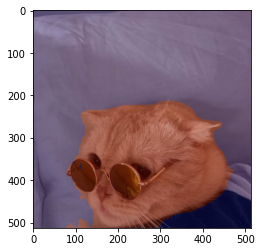

In [14]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출해줄 것이기 때문에 8만 넣어줍니다.
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


사진의 문제점.
경계가 매끄럽지 않다. 고양이가 아닌 다른 부분도 인식이 되었다.   
선글라스는 인식하는 게 신기하다.  
하지만 합성은 매끄러운 상태로 하는게 예쁘니까 다른 사진을 불러와보겠습니다.

In [15]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/3.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig3 = cv2.imread(img_path3) 
print (img_orig3.shape)

#다른 사진을 불러와본다

(951, 1265, 3)


In [16]:
img_resized, seg_map = MODEL.run(img_orig3)
print (img_orig3.shape, img_resized.shape, seg_map.max())

(951, 1265, 3) (385, 513, 3) 8


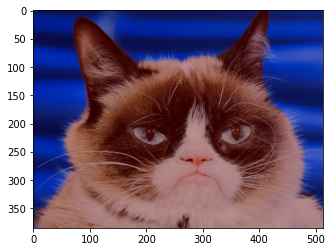

In [17]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#매끄럽게 인식이 된 것 같다

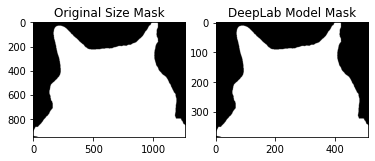

In [18]:
img_mask_up = cv2.resize(img_mask, img_orig3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

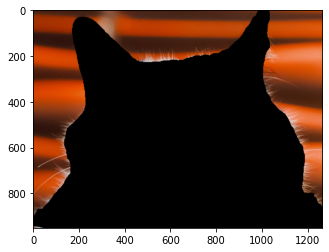

In [19]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig3, img_bg_mask)
plt.imshow(img_bg)
plt.show()
#섬세한 털 부분에서 인식률이 떨어지는게 아쉽다.

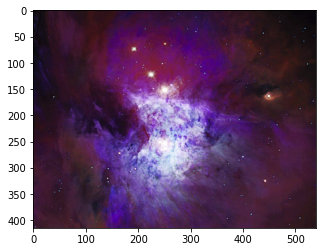

In [20]:
img = os.getenv('HOME')+'/aiffel/human_segmentation/images/33.jpg'
space = cv2.imread(img) 
plt.imshow(space)
plt.show()
#배경이 될 이미지

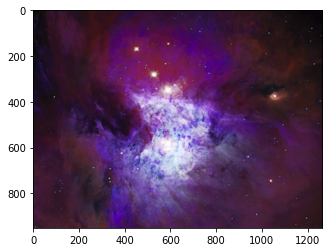

In [21]:
resize = cv2.resize(space, dsize=(1265, 951))
plt.imshow(resize)
plt.show()
#이미지를 합치기 위해 리사이징을 해줍니다.

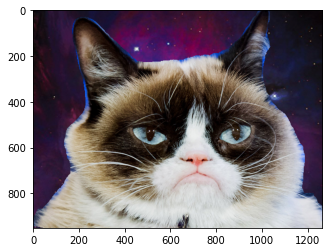

In [22]:
img_concat = np.where(img_mask_color==255, img_orig3, resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
#쨘 고양이를 우주로 보내주었습니다.

# 새롭게 배운 것
`이미지 세그멘테이션(image segmentation)`
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법.   
모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다.


+그래서 그런지 이미지의 화질이 좋으면 세그멘테이션이 더 매끄럽게 수행되는 것 같다.

최근에는 참고사이트[https://www.remove.bg/ko] 같이 자동으로 누끼를 따 주는 사이트들이 많이 생겼는데 어떤 방식으로 경계를 인식하는지 궁금해졌다. 아마 사용자들이 올리는 다양한 이미지들을 신경망이 학습한 후 비슷한 이미지들을 라벨링하여 분류한 후 더 정교하게 변화하는 방식을 택한게 아닐까 하는 예측을 해본다.   

실제로 비슷한 서비스를 제공하는 '이넘컷' 대표의 인터뷰를 참고해봤다.

```머신러닝 기반으로 객체를 검출하고, 단순화된 UX를 적용하다 보니 정밀함이 떨어진 부분도 있다. 예를 들어 세그멘테이션(영역 분할) 기술만 적용했을 때는 안경 같은 이미지도 잘 떼어냈지만, 머신러닝을 적용한 뒤로는 검출이 어려운 안경알 부분이 배경과 잘 분리되지 않는 현상이 발생했다. 유리나 다이아몬드 등 반사 특성을 갖는 객체 이미지 역시 마찬가지다. 이에 대해 최 대표는 “사용자가 서비스를 이용하면 이용할 수록 학습이 돼서 더 정밀도가 올라간다”라며 “결과물이 잘 안 나온 것 중심으로 재학습을 시키고 있다”라고 설명했다.```     


       
세그먼테이션 기술과 강화학습을 잘 활용하면 서비스의 질을 올릴 수 있음을 알 수 있었다. 